# Credit Card Fraud Detection

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import warnings

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Imbalanced data handling
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Ignore warnings
warnings.filterwarnings("ignore")

### EDA

In [2]:
df = pd.read_csv('/Users/afnanag/Desktop/Projects/Card_Fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check for null values
df.isnull().sum().max()

0

In [4]:
# Calculate and print the percentage of each class in the dataset
no_frauds_percent = round(df['Class'].value_counts()[0] / len(df) * 100, 2)
frauds_percent = round(df['Class'].value_counts()[1] / len(df) * 100, 2)

print('No Frauds:', no_frauds_percent, '% of the dataset')
print('Frauds:', frauds_percent, '% of the dataset')

No Frauds: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


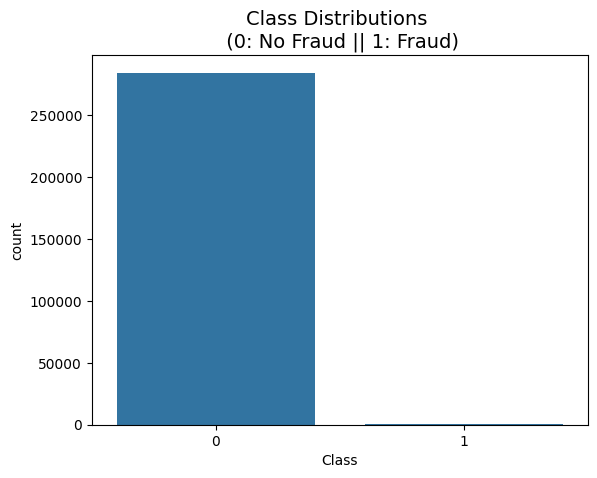

In [5]:
# Plot the count plot
sns.countplot(x='Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

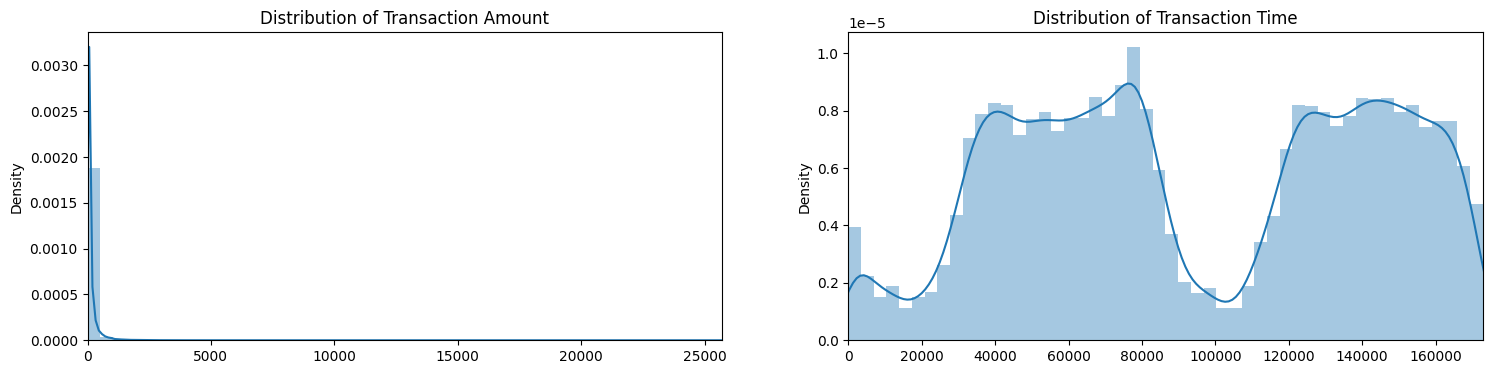

In [6]:
# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Plot distribution of transaction amount
sns.distplot(df['Amount'].values, ax=ax[0],)
ax[0].set_title('Distribution of Transaction Amount')
ax[0].set_xlim([0, df['Amount'].max()])

# Plot distribution of transaction time
sns.distplot(df['Time'].values, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time')
ax[1].set_xlim([0, df['Time'].max()])

# Display the plot
plt.show()

### Preprocessing

In [7]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
rob_scaler = RobustScaler()

# Scale 'Amount' and 'Time' columns
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original 'Time' and 'Amount' columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [8]:
# Rearrange columns with scaled_amount and scaled_time at the beginning
df = df[['scaled_amount', 'scaled_time'] + [col for col in df.columns if col not in ['scaled_amount', 'scaled_time']]]

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
print('No Frauds', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    break

# Convert to arrays
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Check the distribution of the labels
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.998262 0.001738]


In [10]:
# Shuffle the dataframe
df = df.sample(frac=1, random_state=42)

# Amount of fraud and non-fraud classes (assuming fraud is labeled as 1)
fraud_df = df[df['Class'] == 1]
non_fraud_df = df[df['Class'] == 0][:len(fraud_df)]  # Take the same number of non-fraud samples as fraud samples

# Concatenate fraud and non-fraud dataframes to create a balanced dataset
balanced_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

balanced_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
146884,-0.293579,0.038170,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,...,-0.209856,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0
95597,18.615944,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,...,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1
96768,1.872424,-0.220456,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,...,-0.294785,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,0
75511,2.080905,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,...,0.270459,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,1
255556,-0.296653,0.852830,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,...,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


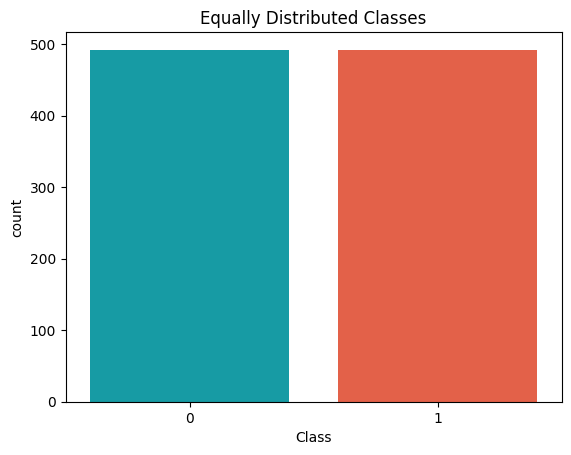

In [11]:
# Calculate and print the distribution of classes in the subsampled dataset
print('Distribution of the Classes in the subsample dataset')
print(balanced_df['Class'].value_counts() / len(balanced_df))

# Define colors for the count plot
colors = ["#00AFBB", "#FC4F30"]

# Plot the count plot
sns.countplot(x='Class', data=balanced_df, palette=colors)
plt.title('Equally Distributed Classes')
plt.show()

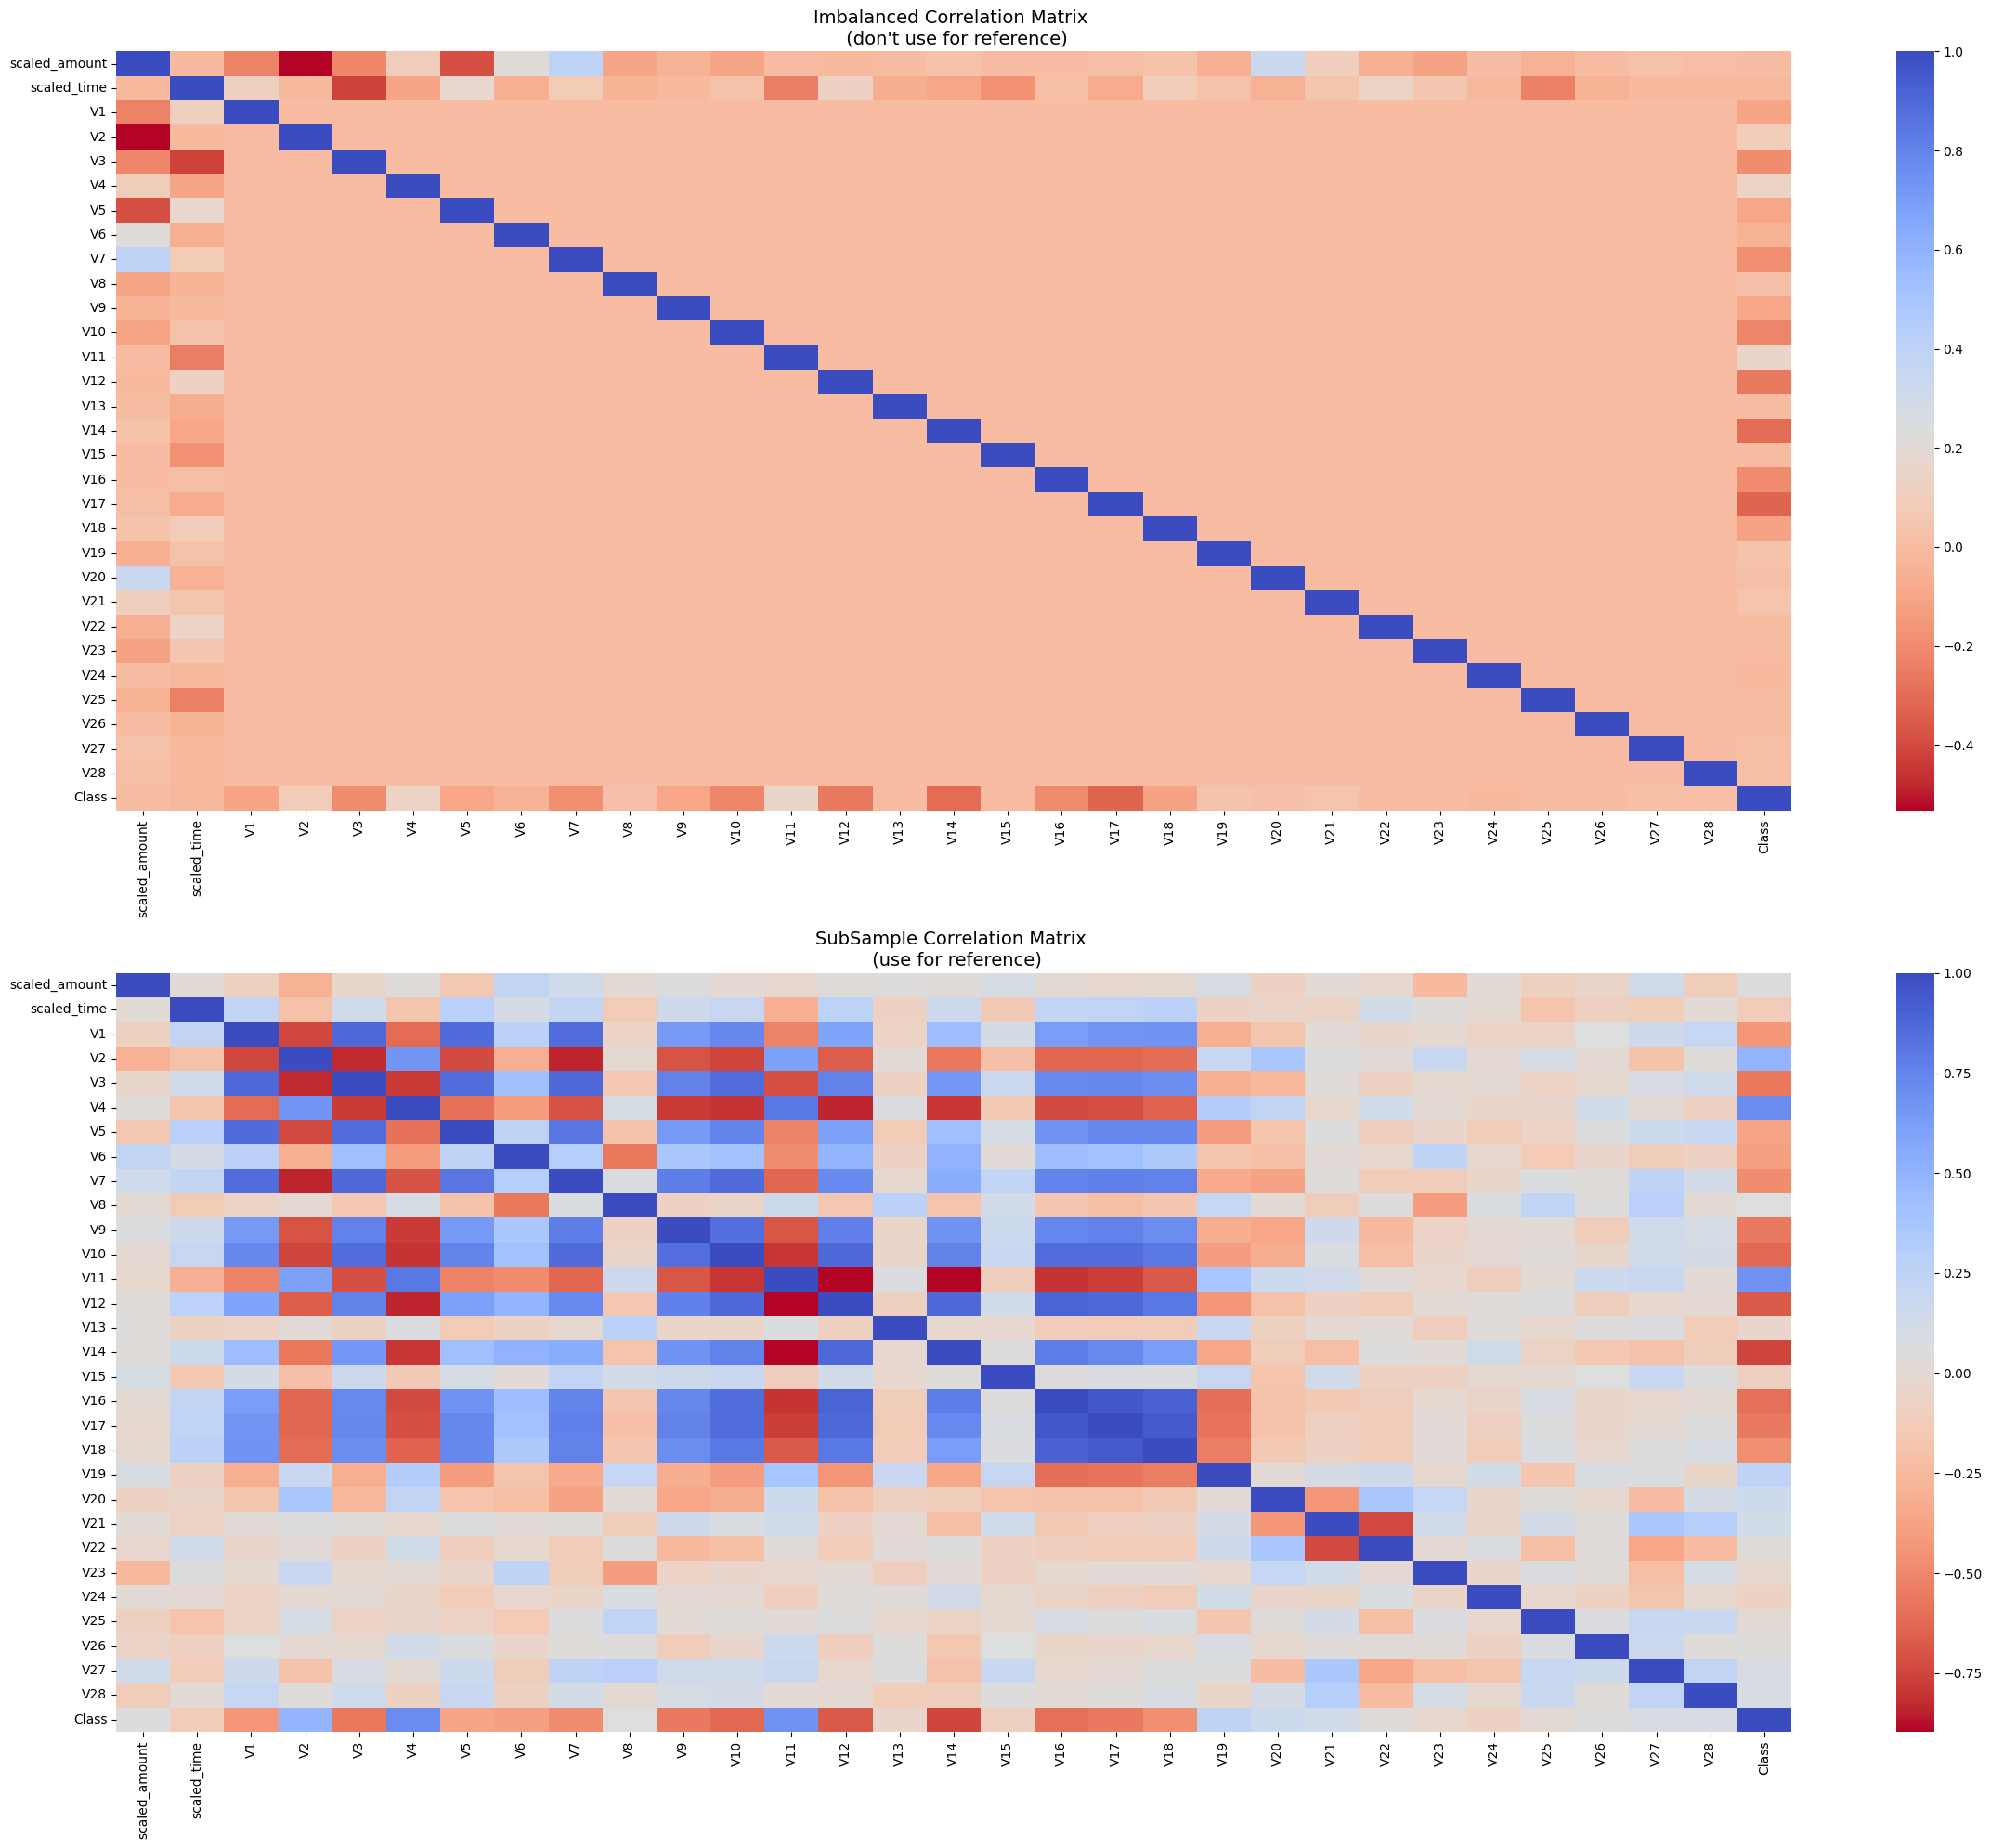

In [12]:
# Set up subplots for the correlation matrices
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Correlation matrix for the entire DataFrame (df)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 14}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Correlation matrix for the subsampled DataFrame
sub_sample_corr = balanced_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size': 14}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

plt.tight_layout()
plt.show()

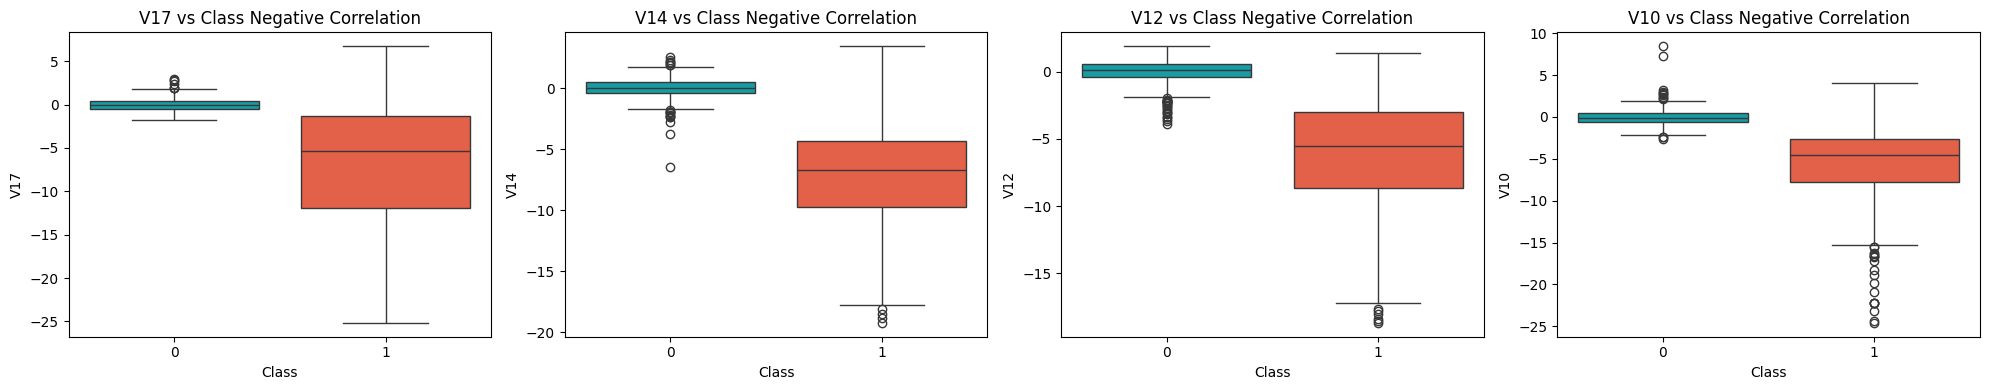

In [13]:
# Set up subplots for the boxplots
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Plot boxplots for negative correlations with 'Class'
sns.boxplot(x="Class", y="V17", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=balanced_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=balanced_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.tight_layout()
plt.show()

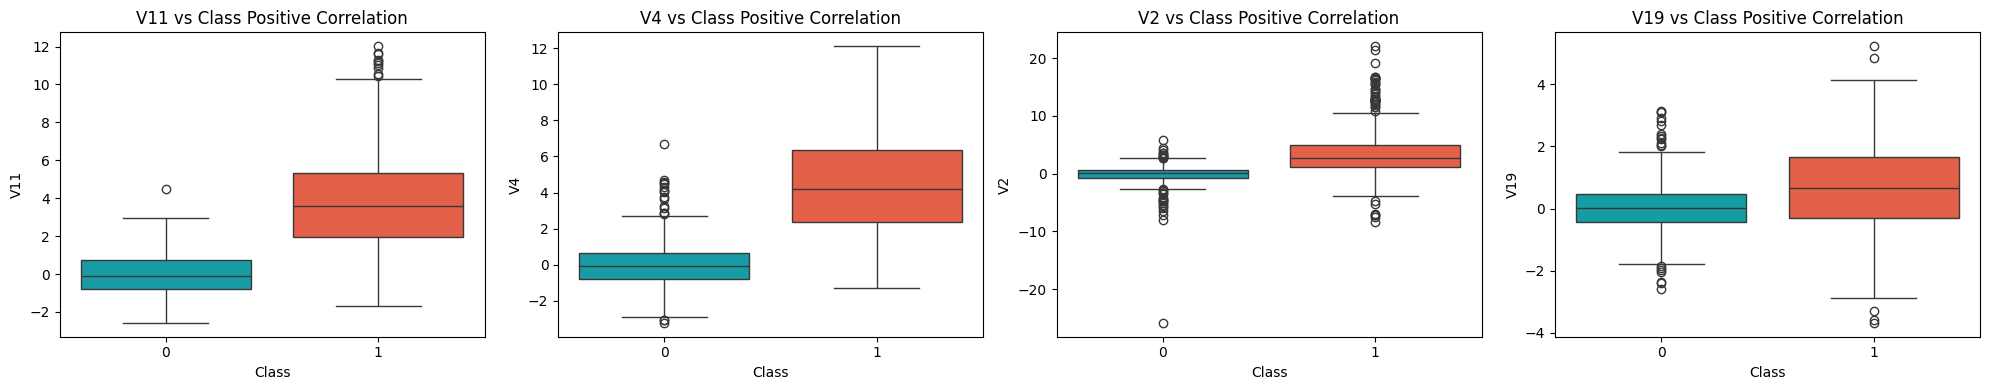

In [14]:
# Set up subplots for the boxplots
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Plot boxplots for positive correlations with 'Class'
sns.boxplot(x="Class", y="V11", data=balanced_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=balanced_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=balanced_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=balanced_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.tight_layout()
plt.show()

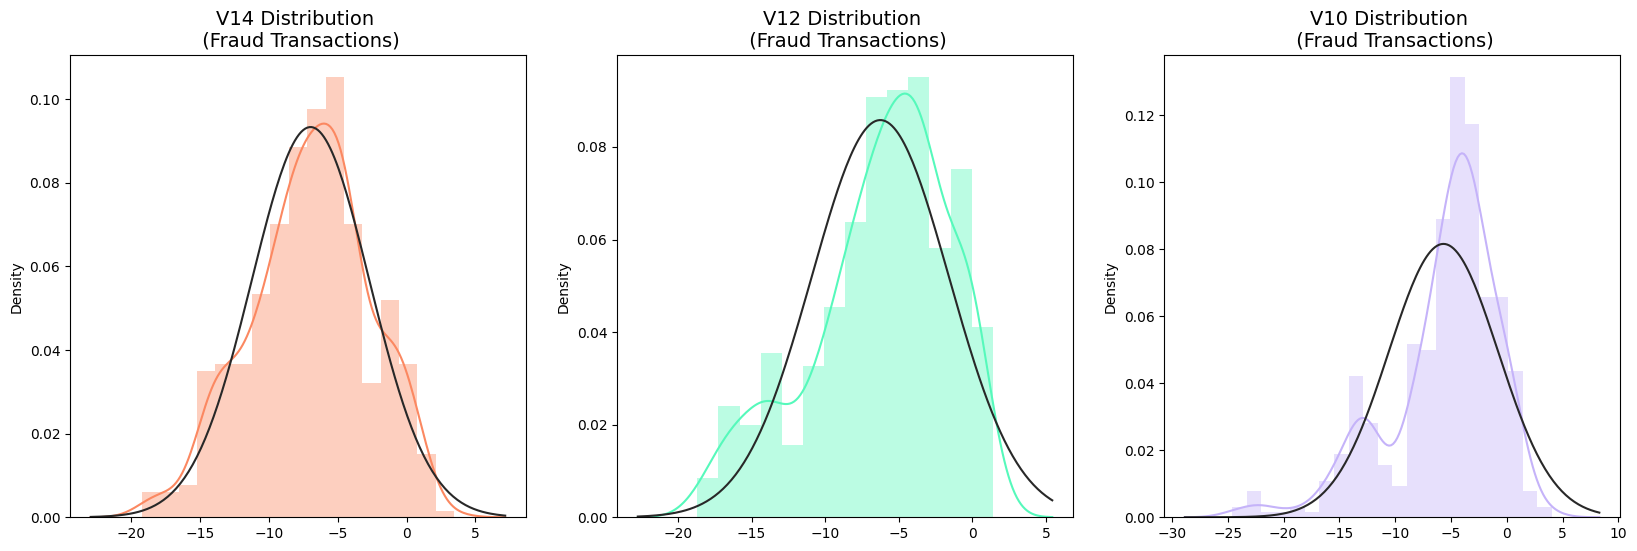

In [15]:
from scipy.stats import norm

# Set up subplots for the distributions
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot distribution of V14 for fraud transactions
v14_fraud_dist = balanced_df['V14'].loc[balanced_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

# Plot distribution of V12 for fraud transactions
v12_fraud_dist = balanced_df['V12'].loc[balanced_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

# Plot distribution of V10 for fraud transactions
v10_fraud_dist = balanced_df['V10'].loc[balanced_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

# Display the plot
plt.show()

In [16]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = balanced_df['V14'].loc[balanced_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

balanced_df = balanced_df.drop(balanced_df[(balanced_df['V14'] > v14_upper) | (balanced_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = balanced_df['V12'].loc[balanced_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
balanced_df = balanced_df.drop(balanced_df[(balanced_df['V12'] > v12_upper) | (balanced_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(balanced_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = balanced_df['V10'].loc[balanced_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
balanced_df = balanced_df.drop(balanced_df[(balanced_df['V10'] > v10_upper) | (balanced_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(balanced_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.0499976898594, -18.4937733551053, -18.8220867423816]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.5536970096458, -18.0475965708216, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.5637913387301, -22.187088

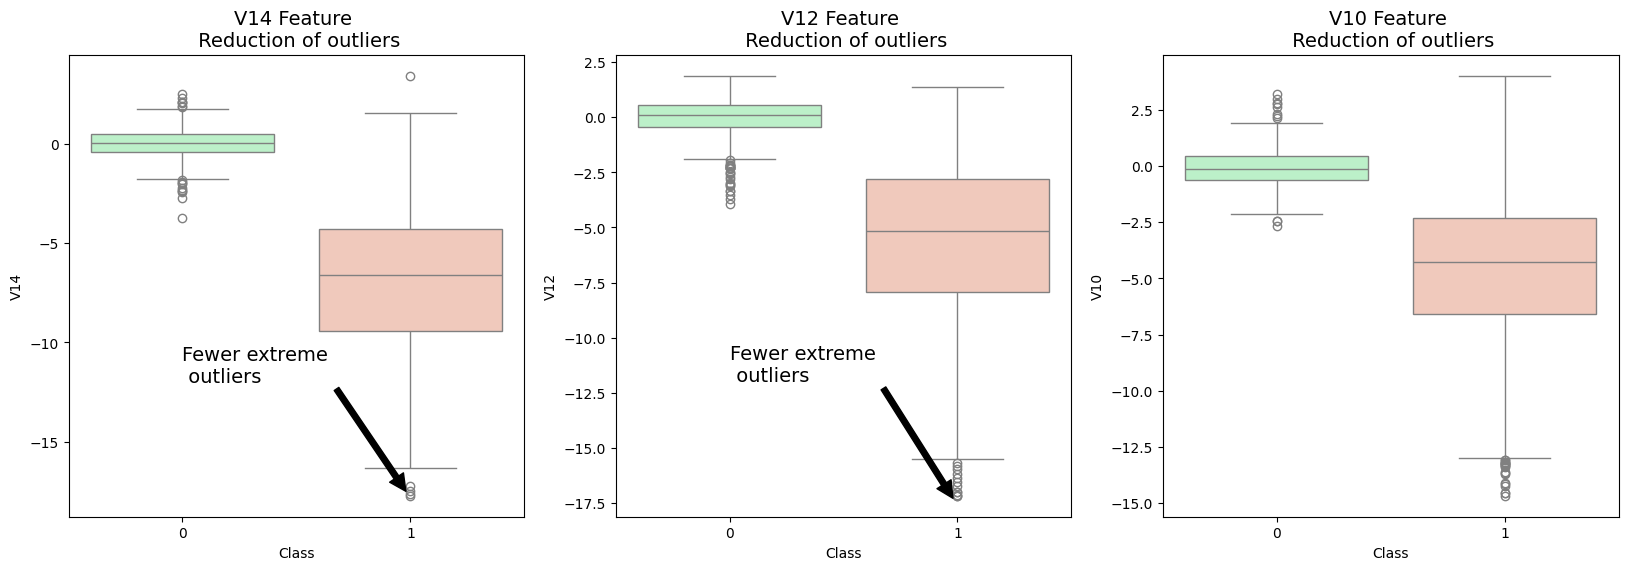

In [17]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=balanced_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=balanced_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=balanced_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

In [18]:
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2f} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2f} s".format(t1 - t0))

# TruncatedSVD Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2f} s".format(t1 - t0))

T-SNE took 3.64 s
PCA took 1.09 s
Truncated SVD took 0.87 s


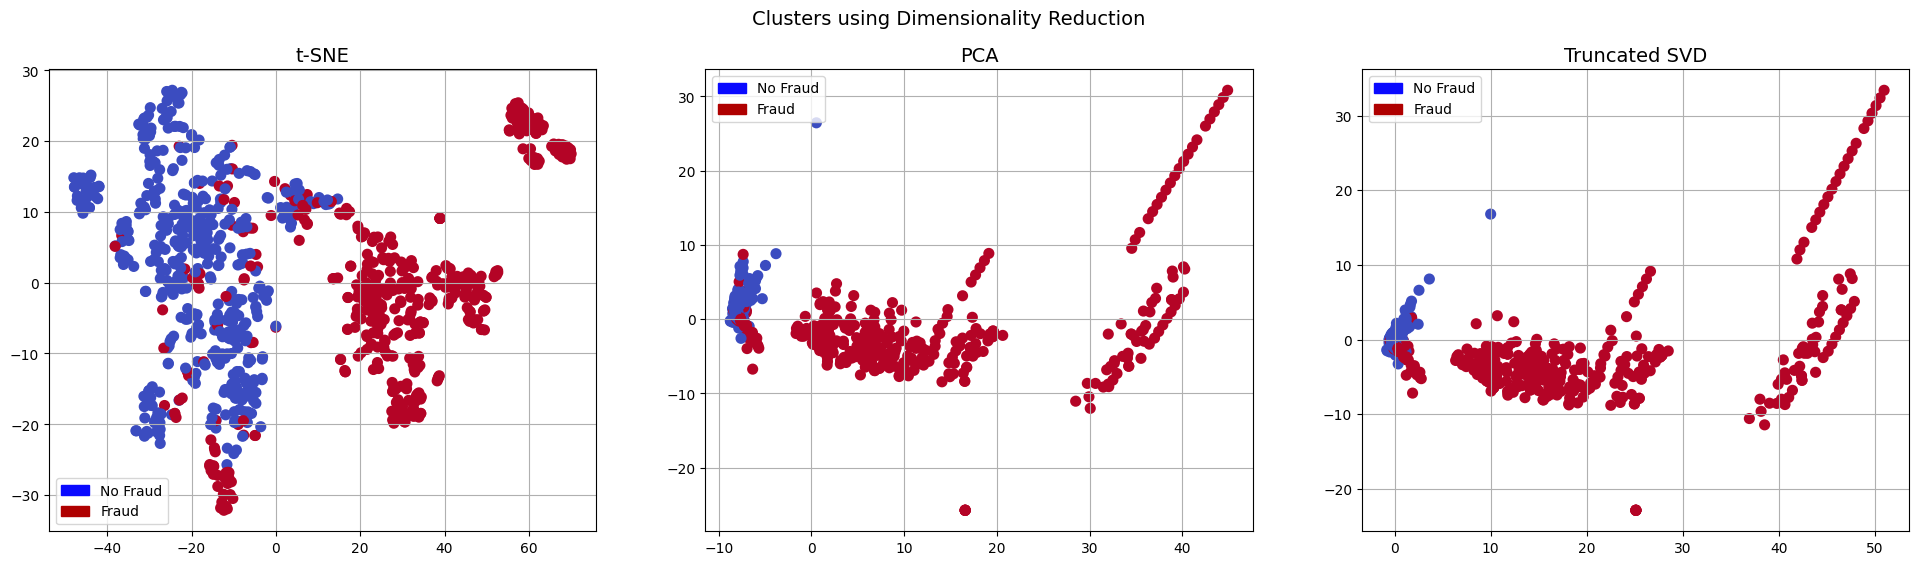

In [19]:
# Create subplots with 1 row and 3 columns
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# Define legend patches
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Model

In [21]:
# Initialize classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [22]:
from sklearn.model_selection import cross_val_score

# Loop through each classifier and print training scores
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Training Score: {round(training_scores.mean(), 2) * 100}% accuracy")
    print("")

Classifier: LogisticRegression
Training Score: 94.0% accuracy

Classifier: KNeighborsClassifier
Training Score: 93.0% accuracy

Classifier: SVC
Training Score: 94.0% accuracy

Classifier: DecisionTreeClassifier
Training Score: 89.0% accuracy



In [23]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {
    "penalty": ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# K-Nearest Neighbors
knears_params = {
    "n_neighbors": list(range(2, 5, 1)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# Decision Tree Classifier
tree_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(2, 4, 1)),
    "min_samples_leaf": list(range(5, 7, 1))
}

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [24]:
# Cross-validation scores
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score:', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('K-Nearest Neighbors Cross Validation Score:', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score:', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('Decision Tree Classifier Cross Validation Score:', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score: 94.32%
K-Nearest Neighbors Cross Validation Score: 93.92%
Support Vector Classifier Cross Validation Score: 93.92%
Decision Tree Classifier Cross Validation Score: 91.55%


In [25]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

# Convert to arrays
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X, undersample_y)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))

Train: [ 56961  56962  56963 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56960 57389]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56961  56962  56963 ... 115149 115895 115915]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113917 113918 113919 ... 174064 175233 176377]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170875 170876 170877 ... 231615 231641 232419]
Train: [     0      1      2 ... 231615 231641 232419] Test: [227839 227840 227841 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [26]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

/Users/afnanag/Desktop/Projects/Card_Fraud/card_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/afnanag/Desktop/Projects/Card_Fraud/card_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

<module 'matplotlib.pyplot' from '/Users/afnanag/Desktop/Projects/Card_Fraud/card_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

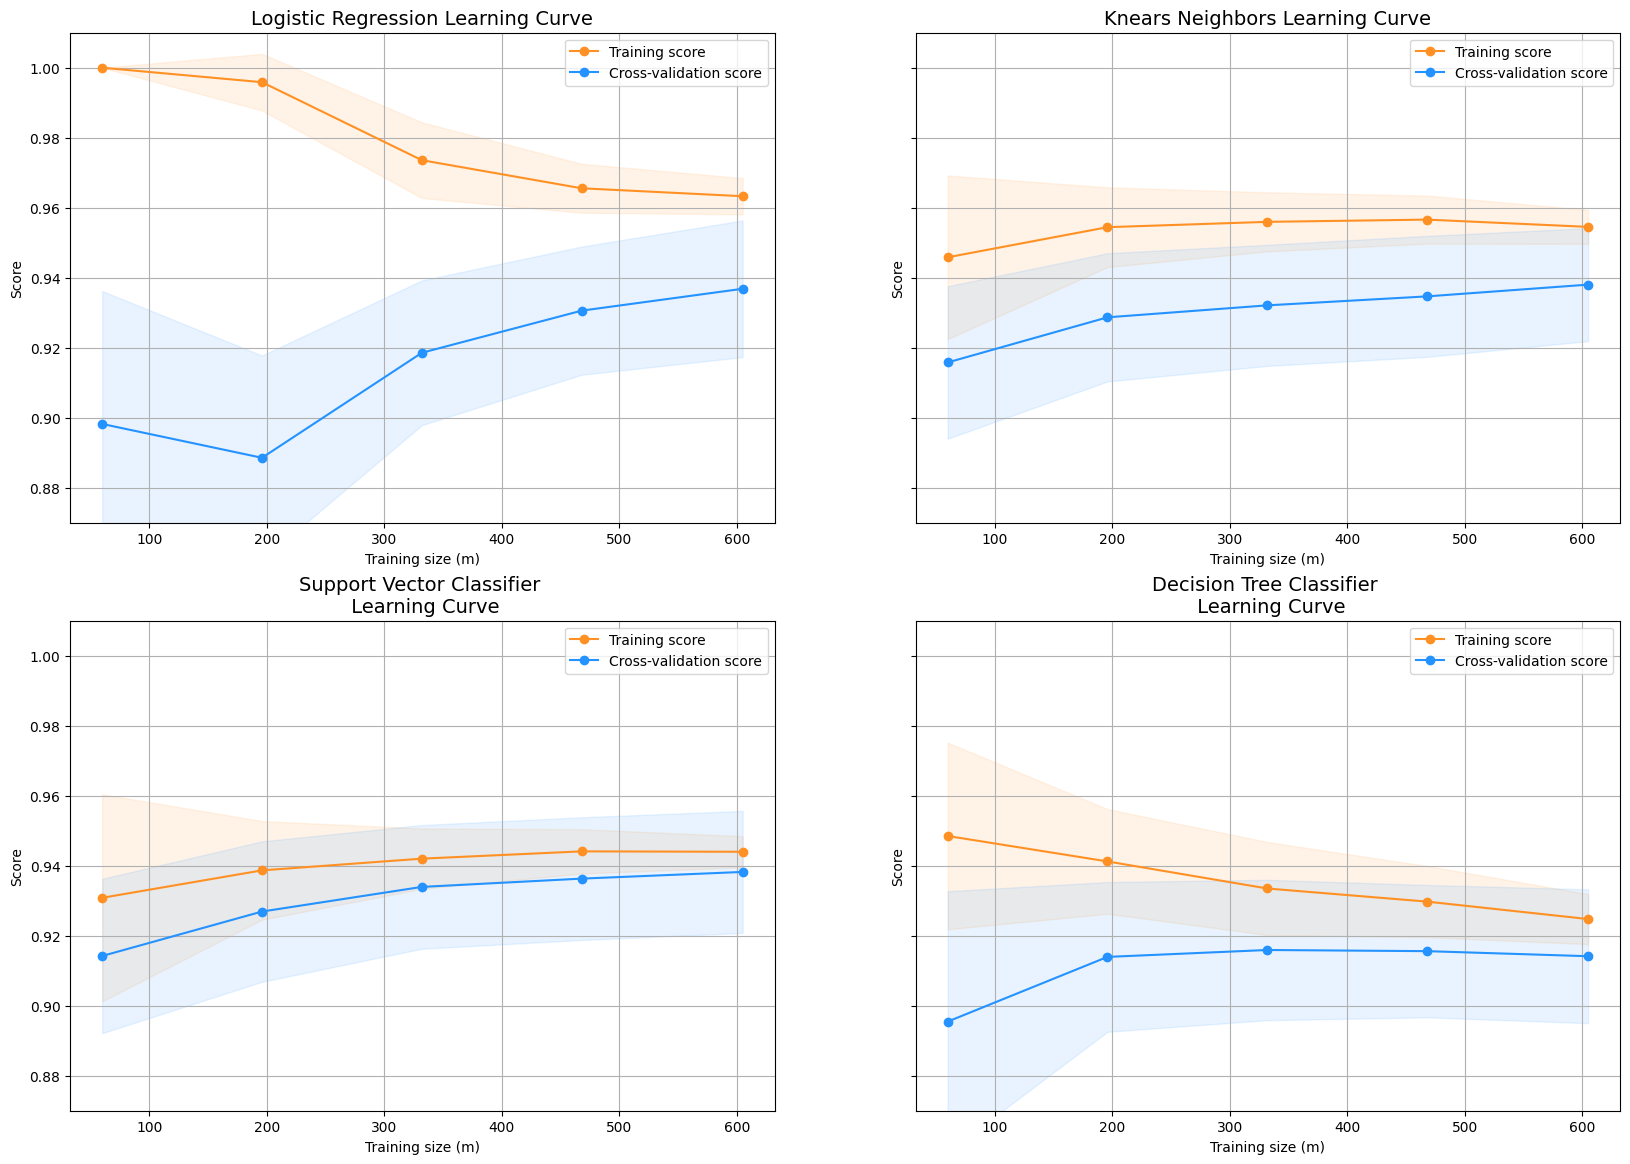

In [27]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [28]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [29]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9695957771523781
KNears Neighbors:  0.9374763724954845
Support Vector Classifier:  0.9788437574382883
Decision Tree Classifier:  0.9113321012027276


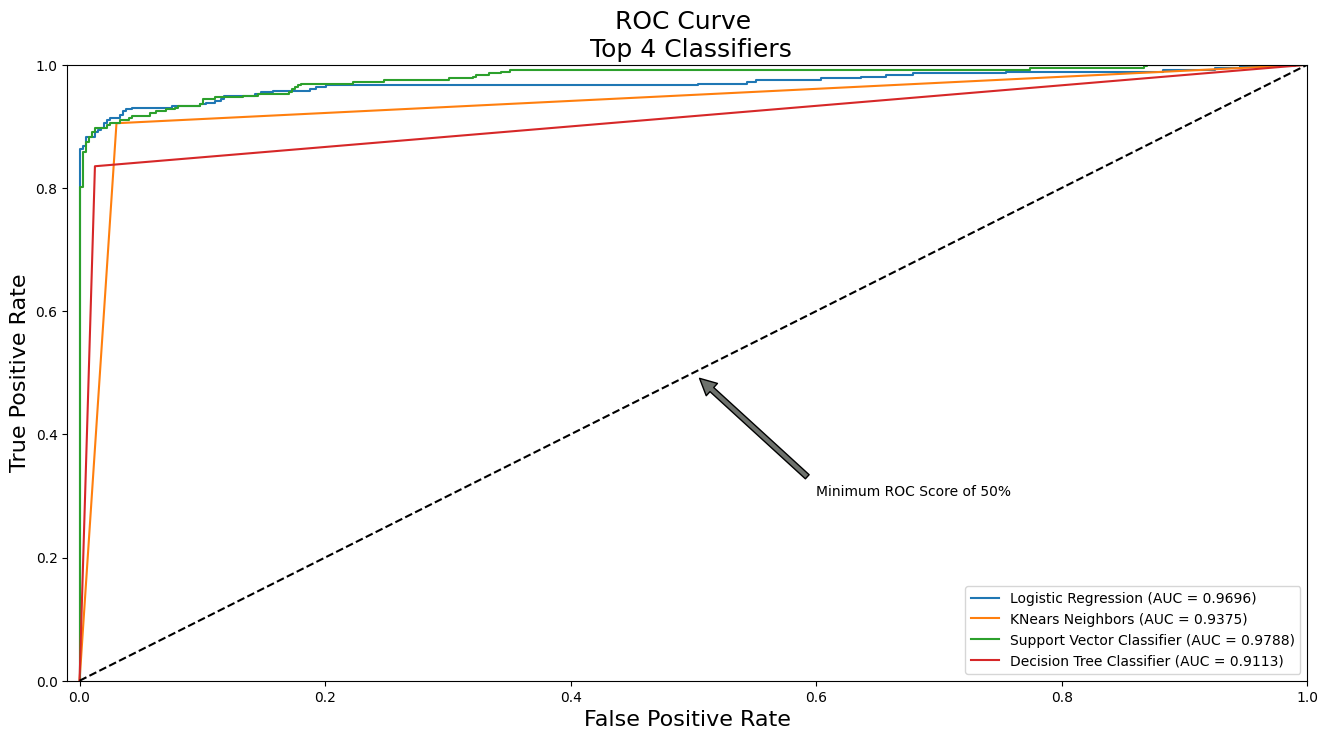

In [30]:
# Calculate ROC curves
log_fpr, log_tpr, _ = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, _ = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, _ = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, _ = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16, 8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    
    # Plot ROC curves
    plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_train, log_reg_pred):.4f})')
    plt.plot(knear_fpr, knear_tpr, label=f'KNears Neighbors (AUC = {roc_auc_score(y_train, knears_pred):.4f})')
    plt.plot(svc_fpr, svc_tpr, label=f'Support Vector Classifier (AUC = {roc_auc_score(y_train, svc_pred):.4f})')
    plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree Classifier (AUC = {roc_auc_score(y_train, tree_pred):.4f})')
    
    # Plot the 50% ROC curve line
    plt.plot([0, 1], [0, 1], 'k--')
    
    # Set plot limits and labels
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
    # Annotation for minimum ROC score
    plt.annotate('Minimum ROC Score of 50%', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    
    # Display legend
    plt.legend()

# Call the function to plot ROC curves
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)

# Show the plot
plt.show()

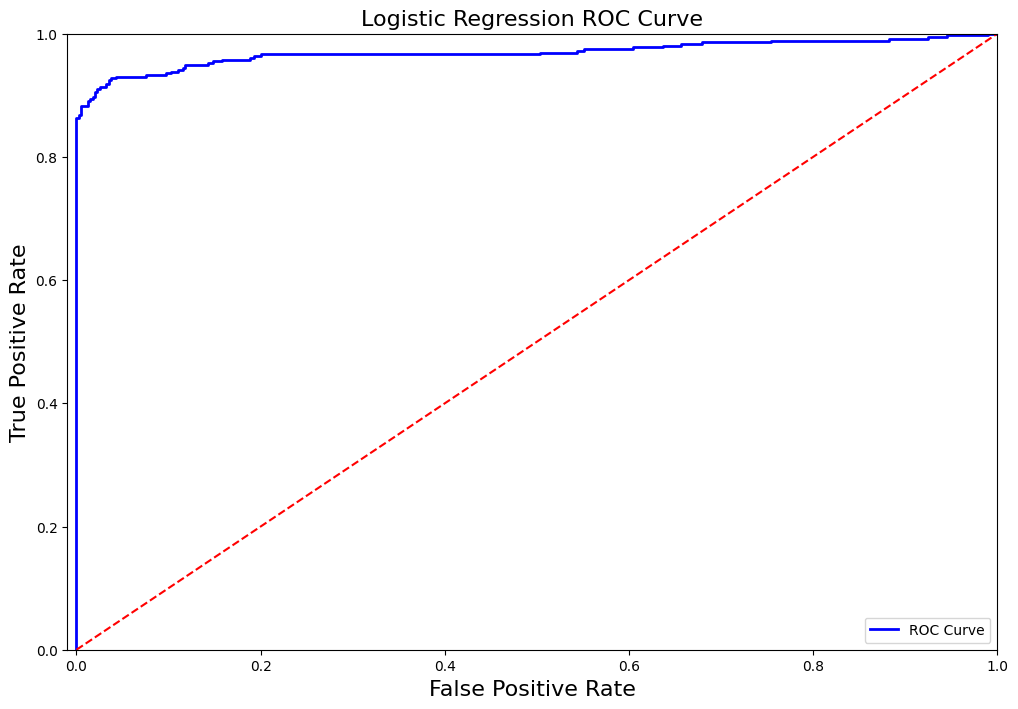

In [31]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12, 8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    plt.axis([-0.01, 1, 0, 1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()


In [32]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [33]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.95
Precision Score: 0.64
F1 Score: 0.76
Accuracy Score: 0.72
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.47
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [34]:
from sklearn.metrics import average_precision_score

undersample_y_score = log_reg.decision_function(original_Xtest)
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

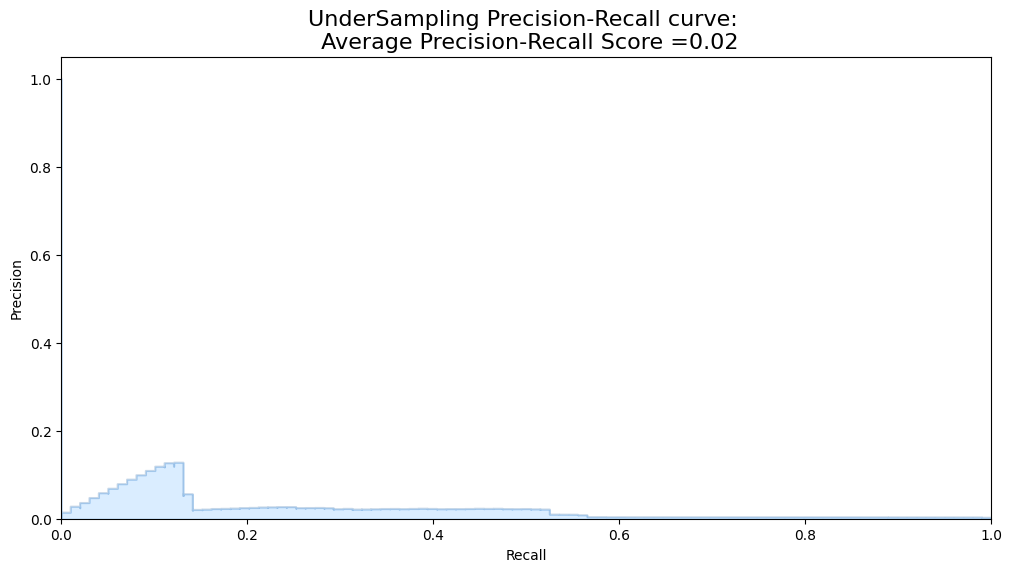

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [36]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(accuracy_score(original_ytrain[test], prediction))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {:.2f}".format(np.mean(accuracy_lst)))
print("precision: {:.2f}".format(np.mean(precision_lst)))
print("recall: {:.2f}".format(np.mean(recall_lst)))
print("f1: {:.2f}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.93
precision: 0.09
recall: 0.90
f1: 0.15
---------------------------------------------------------------------------------------------------------------------------------------


In [37]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.84      0.91     56863
       Fraud       0.01      0.92      0.02        99

    accuracy                           0.84     56962
   macro avg       0.50      0.88      0.47     56962
weighted avg       1.00      0.84      0.91     56962



In [38]:
y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.57


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.57')

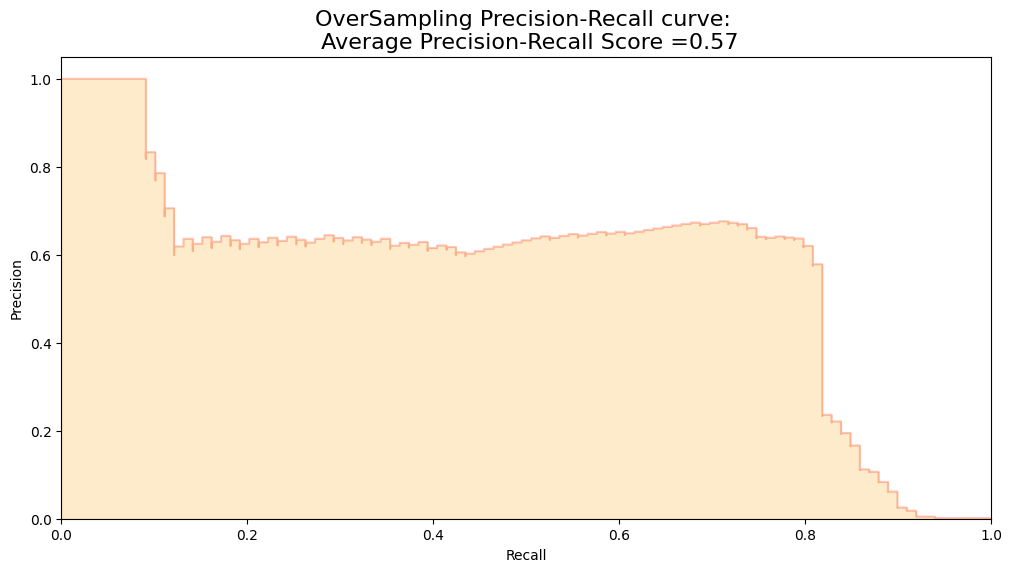

In [39]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [40]:
# Define the SMOTE object
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to resample the training data
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)


In [41]:
# Start timing the fitting process
t0 = time.time()

# Fit the best estimator found by GridSearchCV on the oversampled data
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

# End timing
t1 = time.time()

print("Fitting oversampled data took: {:.2f} sec".format(t1 - t0))

Fitting oversampled data took: 2.18 sec


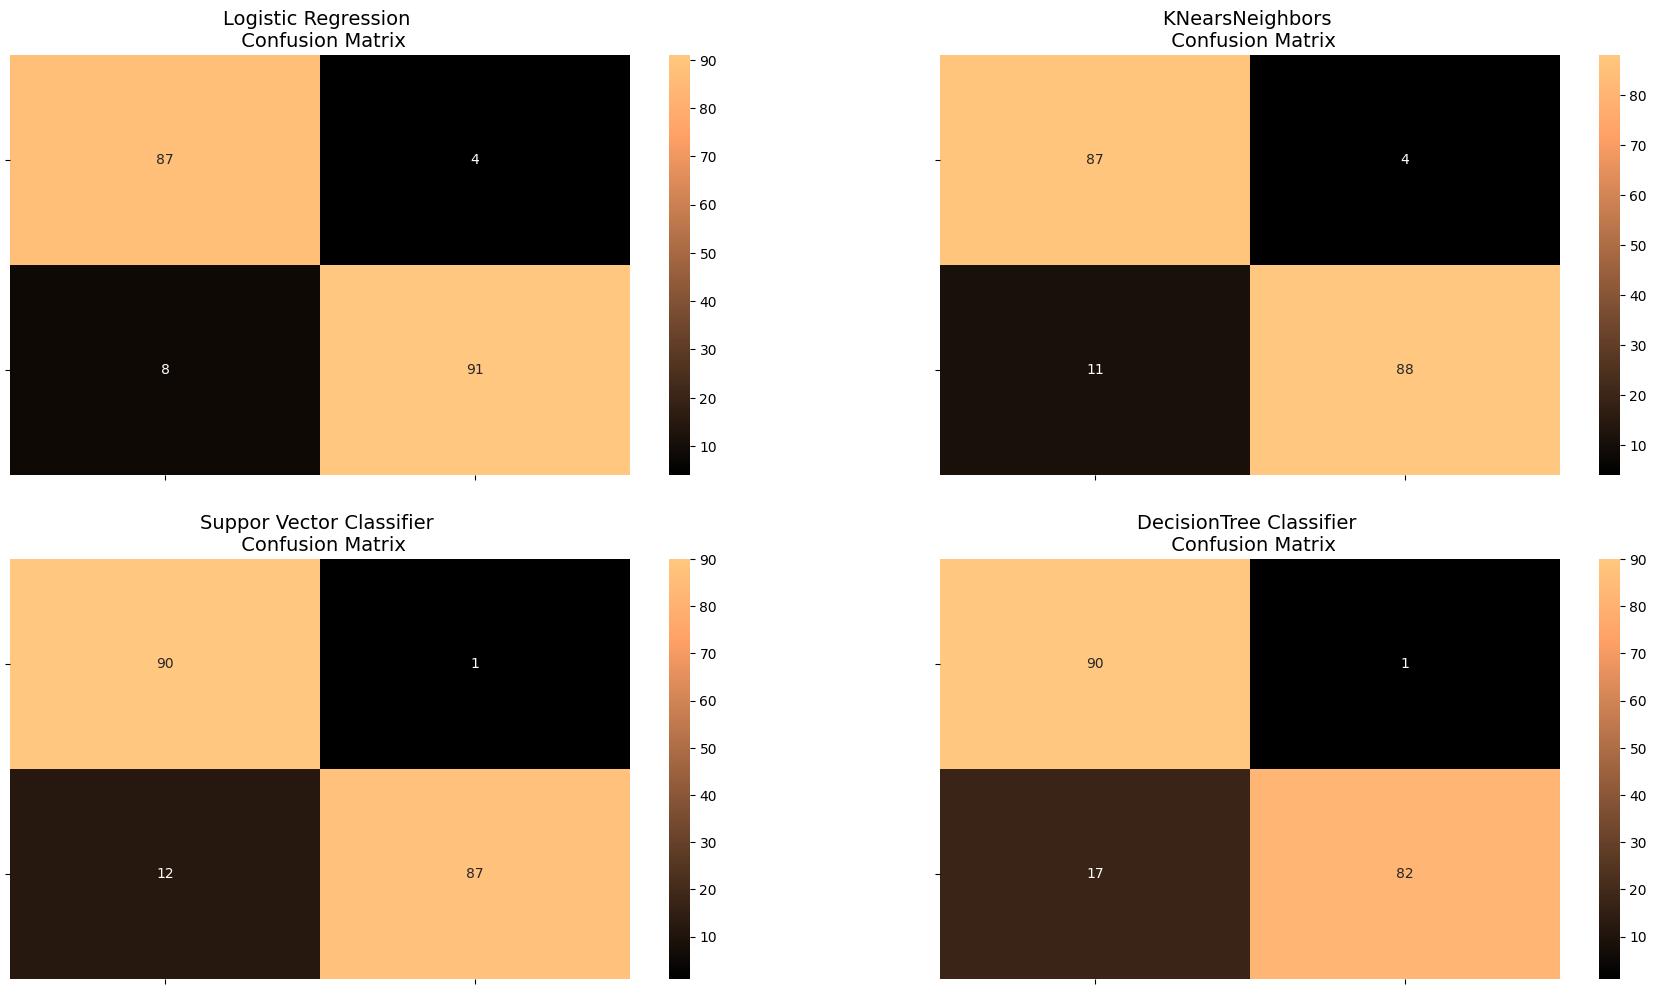

In [42]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [43]:
from sklearn.metrics import classification_report

# Logistic Regression
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

# KNears Neighbors
print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

# Support Vector Classifier
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

# Decision Tree Classifier
print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        91
           1       0.96      0.92      0.94        99

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        91
           1       0.96      0.89      0.92        99

    accuracy                           0.92       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.92      0.92      0.92       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        91
           1       0.99      0.88      0.93        99

    accuracy                           0.93       190
   macro avg       0.94      0.93      0.93       190
weighted

In [44]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred_undersample = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred_undersample)

# Logistic Regression with SMOTE Technique
y_pred_oversample = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_oversample)

# Creating a DataFrame to display the scores
d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Displaying the DataFrame with adjusted column order
final_df = final_df[['Technique', 'Score']]

final_df

,Technique,Score
0,Random UnderSampling,0.936842
1,Oversampling (SMOTE),0.839103


In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

# Print model summary
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-07-11 16:48:42.278505: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-11 16:48:42.278529: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-11 16:48:42.278538: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-11 16:48:42.278575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 16:48:42.278590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [46]:
from keras.optimizers import Adam
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20


2024-07-11 16:48:42.577673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 1s - loss: 0.5555 - accuracy: 0.6876 - val_loss: 0.3888 - val_accuracy: 0.7829 - 657ms/epoch - 26ms/step
Epoch 2/20


2024-07-11 16:48:42.997445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 0s - loss: 0.3625 - accuracy: 0.8430 - val_loss: 0.3159 - val_accuracy: 0.8947 - 138ms/epoch - 6ms/step
Epoch 3/20
25/25 - 0s - loss: 0.2834 - accuracy: 0.8942 - val_loss: 0.2403 - val_accuracy: 0.9276 - 137ms/epoch - 5ms/step
Epoch 4/20
25/25 - 0s - loss: 0.2389 - accuracy: 0.9190 - val_loss: 0.2172 - val_accuracy: 0.9276 - 135ms/epoch - 5ms/step
Epoch 5/20
25/25 - 0s - loss: 0.2122 - accuracy: 0.9372 - val_loss: 0.1965 - val_accuracy: 0.9342 - 136ms/epoch - 5ms/step
Epoch 6/20
25/25 - 0s - loss: 0.1960 - accuracy: 0.9405 - val_loss: 0.1843 - val_accuracy: 0.9408 - 136ms/epoch - 5ms/step
Epoch 7/20
25/25 - 0s - loss: 0.1827 - accuracy: 0.9405 - val_loss: 0.1680 - val_accuracy: 0.9342 - 135ms/epoch - 5ms/step
Epoch 8/20
25/25 - 0s - loss: 0.1751 - accuracy: 0.9455 - val_loss: 0.1514 - val_accuracy: 0.9408 - 135ms/epoch - 5ms/step
Epoch 9/20
25/25 - 0s - loss: 0.1708 - accuracy: 0.9405 - val_loss: 0.1704 - val_accuracy: 0.9342 - 138ms/epoch - 6ms/step
Epoch 10/20
25/25 - 0s - lo

In [48]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

2024-07-11 16:48:45.804495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [49]:
undersample_fraud_predictions = np.argmax(undersample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=1)

In [50]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

    # Show plot
    plt.show()

Confusion matrix, without normalization


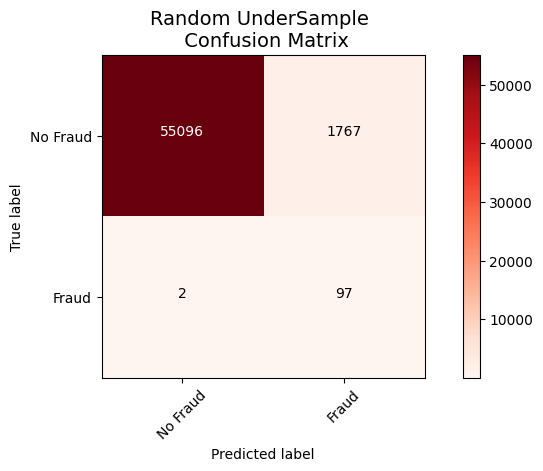

Confusion matrix, without normalization


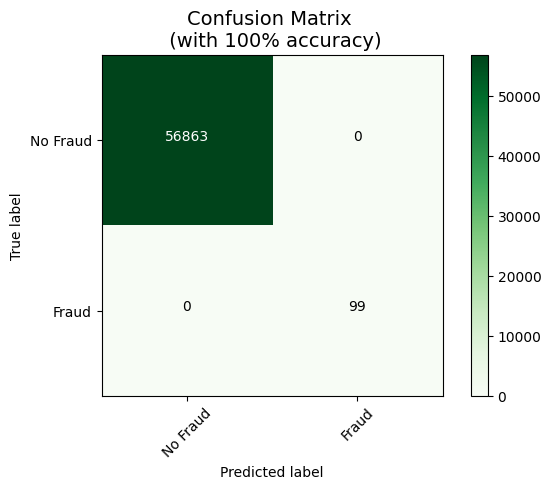

In [59]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)
plt.show()

In [63]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [64]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20


2024-07-11 16:54:04.671328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-11 16:54:09.982139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1214/1214 - 6s - loss: 0.1567 - accuracy: 0.9422 - val_loss: 0.1942 - val_accuracy: 0.9004 - 6s/epoch - 5ms/step
Epoch 2/20
1214/1214 - 6s - loss: 0.1396 - accuracy: 0.9491 - val_loss: 0.2480 - val_accuracy: 0.8910 - 6s/epoch - 5ms/step
Epoch 3/20
1214/1214 - 6s - loss: 0.1644 - accuracy: 0.9445 - val_loss: 0.2653 - val_accuracy: 0.9153 - 6s/epoch - 5ms/step
Epoch 4/20
1214/1214 - 6s - loss: 0.2084 - accuracy: 0.9386 - val_loss: 0.4252 - val_accuracy: 0.8746 - 6s/epoch - 5ms/step
Epoch 5/20
1214/1214 - 5s - loss: 0.2520 - accuracy: 0.9353 - val_loss: 0.4348 - val_accuracy: 0.8720 - 5s/epoch - 5ms/step
Epoch 6/20
1214/1214 - 6s - loss: 0.3082 - accuracy: 0.9318 - val_loss: 0.6357 - val_accuracy: 0.9104 - 6s/epoch - 5ms/step
Epoch 7/20
1214/1214 - 6s - loss: 0.3767 - accuracy: 0.9305 - val_loss: 0.5625 - val_accuracy: 0.9142 - 6s/epoch - 5ms/step
Epoch 8/20
1214/1214 - 6s - loss: 0.3983 - accuracy: 0.9306 - val_loss: 0.3809 - val_accuracy: 0.9293 - 6s/epoch - 5ms/step
Epoch 9/20
1214/121

In [66]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

2024-07-11 16:56:00.466001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [67]:
oversample_fraud_predictions = np.argmax(oversample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=1)

Confusion matrix, without normalization


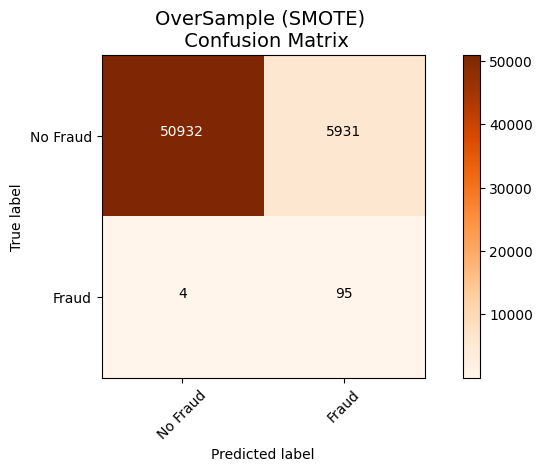

Confusion matrix, without normalization


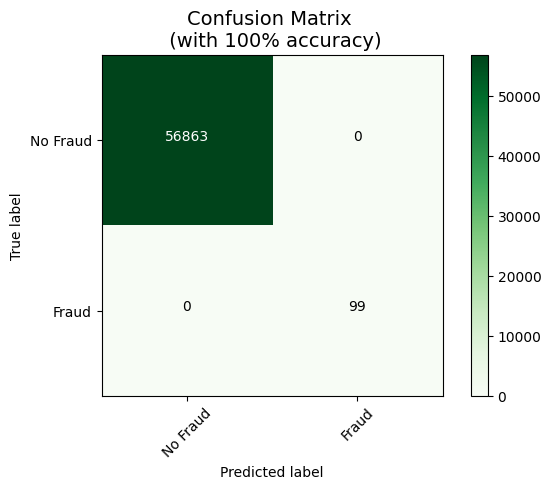

In [68]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [72]:
from sklearn.metrics import precision_score

# Example usage with Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)
precision_log_reg = precision_score(y_test, y_pred_log_reg)

# Similarly, compute precision for other models
y_pred_knear = knears_neighbors.predict(X_test)
precision_knear = precision_score(y_test, y_pred_knear)

y_pred_svc = svc.predict(X_test)
precision_svc = precision_score(y_test, y_pred_svc)

y_pred_tree = tree_clf.predict(X_test)
precision_tree = precision_score(y_test, y_pred_tree)

# Print or use precision scores as needed
print('Precision (Logistic Regression): {:.2f}'.format(precision_log_reg))
print('Precision (KNears Neighbors): {:.2f}'.format(precision_knear))
print('Precision (Support Vector Classifier): {:.2f}'.format(precision_svc))
print('Precision (Decision Tree Classifier): {:.2f}'.format(precision_tree))

Precision (Logistic Regression): 0.96
Precision (KNears Neighbors): 0.96
Precision (Support Vector Classifier): 0.99
Precision (Decision Tree Classifier): 0.99
